In [6]:
# import csv file with spectrum
import pandas as pd

# name of csv spectral data to normalise
path_spec_raw = './spec_o_Her.csv'

spec_raw = pd.read_csv(path_spec_raw)

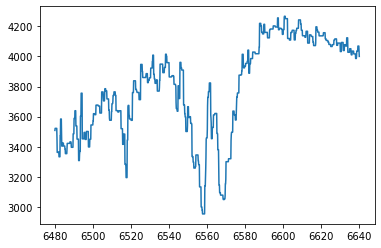

In [13]:
import astropy.units as u
from specutils.spectra import Spectrum1D
import matplotlib.pyplot as plt
from specutils.manipulation import median_smooth

# flux unit NOT REAL - hack to allow Spectrum1D to load since it has to be
# astropy type Quantity
flux = spec_raw['Signal'].to_numpy() * u.Jy
wavelength = spec_raw['Lambda'].to_numpy() * 1e10 * u.AA

# initialise spectrum
spec1d_raw = Spectrum1D(spectral_axis=wavelength, flux=flux)

# smoothening to remove cosmic rays; increase WIDTH until removed
# TODO improve to do properly, not this stupid way
spec1d = median_smooth(spec1d_raw, width=7)

# plot to see loaded spectrum
ax = plt.subplots()[1]
ax.plot(spec1d.spectral_axis, spec1d.flux)

Text(0.5, 1.0, 'Continuum Fitting')

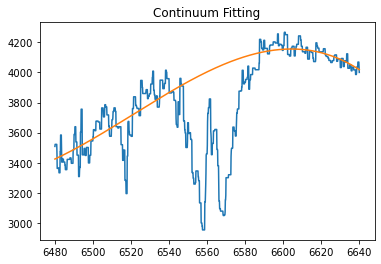

In [20]:
import warnings
from specutils.spectra import Spectrum1D,SpectralRegion
from specutils.fitting import fit_generic_continuum, fit_continuum
from astropy.modeling.models import Chebyshev1D

# regions of continuum in the original spectrum - these are to be fitted on
region = [
    (6480*u.AA, 6510*u.AA),
    (6530*u.AA, 6550*u.AA),
    (6590*u.AA, 6650*u.AA)
]

# produce the fit on the continuum using the regions provided above
# to get the best fit, modify the MODEL orded of the Chebyshev polynomials
# WARNING: take care NOT TO overfit the spectrum, so increase order carefully
# NB: it is better to use odd order of polynomials (#TODO expand on why exactly)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # here, g1_fit produces a model; see below for use
    g1_fit = fit_continuum(spec1d, model=Chebyshev1D(3), window=region)

# g1_fit accepts values for the x-axis and produces the respective values for 
# the y-axis given the fit it calculated
continuum_fit = g1_fit(spec1d.spectral_axis)

# plot the fit over the raw data
f, ax = plt.subplots()
ax.plot(spec1d.spectral_axis, spec1d.flux)
ax.plot(spec1d.spectral_axis, continuum_fit)
ax.set_title('Continuum Fitting')

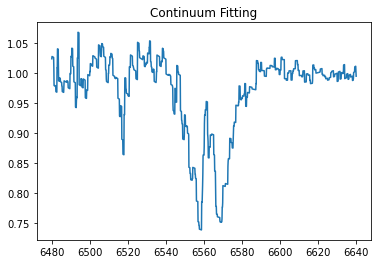

In [21]:
# normalise the raw data with the fitted continuum
spec_normalised = spec1d / continuum_fit

# plot the normalised spectrum to examine the normalised spectrum
f, ax = plt.subplots()
ax.plot(spec_normalised.spectral_axis, spec_normalised.flux)
ax.set_title('Continuum Fitting')


from pandas import DataFrame

# create a pandas DataFrame in order to write results to csv quickly (i am dumb
# and this is the only way I know how, therefore this is THE way to do it)
file_to_save = DataFrame()
file_to_save['Lambda_AA'] = spec_normalised.spectral_axis.value
file_to_save['Normalised_Signal'] = spec_normalised.flux.value

file_to_save.to_csv('o-Her-normalised.csv', index=False)